In [1]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

from datetime import datetime, timedelta

import pylab

In [2]:
datapath = '../data/'

In [3]:
import glob
files = glob.glob(datapath+'*.csv')
files[0]

'../data/FC3DC207-9459-4CBE-8AB5-0E0AC77D5FEC.csv'

In [4]:
dfs = [pd.read_csv(f) for f in files]
#dfs[1] = dfs[1].rename(columns={" timestamp ": "timestamp"})

In [5]:
for df in dfs:
    df.columns = df.columns.str.strip()
    df['mag'] = np.sqrt(df['x']**2+df['y']**2+df['z']**2)
    df['time'] = pd.to_datetime(df['timestamp'], unit='ms')


In [6]:
def prepare_dfs(dfs,window):
    sorted_dfs = []
    rolling_mean = []
    rolling_std = []
    for df in dfs:
        _temp = df.sort_values(by='time')
        _temp = _temp.set_index(['time'])

        _mean = _temp.rolling(window).mean()
        _std = _temp.rolling(window).std()
    
        sorted_dfs.append(_temp)
        rolling_mean.append(_mean)
        rolling_std.append(_std)
    
    return sorted_dfs, rolling_mean, rolling_std




In [31]:
def Find_events(dfs, variable, window):
    events_df = pd.DataFrame()
    drivers = []
    for i in range(0,25):
        test = dfs[i].sort_values(by='time')
        test = test.set_index(['time'])

        test2 = test.rolling(window).mean()
        test2_std = test.rolling(window).std()

        for j in range(0,len(test.index)):
            if test[variable][j] > (test2[variable][j]+(2.75*test2_std[variable][j])):
                if test[variable][j] > (test[variable].mean()+(5.0*test[variable].std())):
                    print(i,test2.index[j],test[variable][j],test2[variable][j],test2_std[variable][j],test[variable].max(),test[variable].mean(),test[variable].std() )
                    events_df = events_df.append(test.iloc[j])
                    drivers.append(i)
    events_df['driver']=drivers
    return events_df
                

In [32]:
def Gather_info(event, dfs, gps, time):
    
    speed_mean_before=[]
    speed_mean_after =[]
    acc_mean_before=[]
    acc_mean_after =[]    
    distance_sum_after = []
    bearing_range_before = []
    bearing_range_after = []
    
    for i in range(0,len(event.index)):
        
        before = dfs[event.driver[i]][ (dfs[event.driver[i]].index> (event.index[i]-timedelta(seconds=time) )) & 
                       (dfs[event.driver[i]].index< (event.index[i]))]

        after = dfs[event.driver[i]][ (dfs[event.driver[i]].index> (event.index[i]))]# & 
        #               (dfs[event.driver[i]].index< (event.index[i]+timedelta(seconds=time) ))]
        
        speed_mean_before.append(before.speed.mean())
        speed_mean_after.append(after.speed.mean())
        acc_mean_before.append(before.mag.mean())
        acc_mean_after.append(after.mag.mean())
        
        
        gps_after = gps[event.driver[i]][ gps[event.driver[i]].index> (event.index[i])]
        distance_sum_after.append(gps_after.distance.sum())
        
        gps_before = gps[event.driver[i]][ (gps[event.driver[i]].index> (event.index[i]-timedelta(seconds=10) )) & 
                       (gps[event.driver[i]].index< (event.index[i]))]
        
        gps_after = gps[event.driver[i]][ (gps[event.driver[i]].index> (event.index[i])) & 
                       (gps[event.driver[i]].index< (event.index[i]+timedelta(seconds=10) ))]
        
        bearing_range_before.append(gps_before.bearing.max() - gps_before.bearing.min())
        bearing_range_after.append(gps_after.bearing.max() - gps_after.bearing.min())
        if event.driver[i] == 3:
            print(gps_before.bearing.max(),gps_before.bearing.min())
            print(gps_after.bearing.max(),gps_after.bearing.min())
            print(bearing_range_before, bearing_range_after)
        
        
    event['speed_before'] = speed_mean_before
    event['speed_after']  = speed_mean_after     
    event['mag_before']   = acc_mean_before    
    event['mag_after']    = acc_mean_after
    event['distance_after'] = distance_sum_after
    event['bearing_before'] = bearing_range_before
    event['bearing_after'] = bearing_range_after
    
    return event
    
    
    

In [33]:
def Plot_crash(event, raw_profile, rolling_mean):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9,9))
    
    ax1.plot(raw_profile.index,raw_profile.mag)
    ax1.plot(rolling_mean.index, rolling_mean.mag)
    ax1.plot(event.index,event.mag, marker='*',markersize=20,c='k')
 
    ax2.plot(raw_profile.index,raw_profile.mag)
    ax2.plot(rolling_mean.index, rolling_mean.mag)
    ax2.plot(event.index,event.mag, marker='*',markersize=20,c='k')
    ax2.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
             
    speed_df = raw_profile[['speed','lat','lon','height']].dropna(axis=0)
    ax3.plot(speed_df.index,speed_df.speed)
    ax3.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    
    ax4.plot(speed_df.index,speed_df.speed)
    ax4.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    ax4.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-1, event.speed_before[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-3, event.speed_after[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-5, event.mag_before[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-7, event.mag_after[0])
    
    
    
    
    plt.show()

In [34]:
def Calc_distance(dfs):
    new_df = []
    for df in dfs:
        _df = df[['lat','lon','bearing']].dropna(axis=0)
        distance = []
        distance.append(0.)
        summed_distance = []
        summed_distance.append(0.)
        for i in range(1,len(_df.index)):
            lat1 = np.radians(_df.lat.iloc[i-1])
            lat2 = np.radians(_df.lat.iloc[i])
            lon1 = np.radians(_df.lon.iloc[i-1])
            lon2 = np.radians(_df.lon.iloc[i])

            a = (np.sin((lat2 - lat1)/2))**2 + (np.cos(lat1) * np.cos(lat2) * (np.sin((lon2 - lon1)/2))**2)
            c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1 - a))
            #sofar = np.sum(distance)
            d = (6371.0*c)
            distance.append(d)
            summed_distance.append(d + summed_distance[i-1])
        _df['distance'] = distance
        _df['summed_distance'] = summed_distance
        new_df.append(_df)
    return new_df
        

In [35]:
new_dfs = Calc_distance(dfs)
sorted_dfs, rolling_mean, rolling_std = prepare_dfs(dfs,'1s')
gps_dfs = Calc_distance(sorted_dfs)
event = Find_events(dfs,'mag','1s')
event = Gather_info(event, sorted_dfs, gps_dfs, 30)

0 2015-05-07 21:51:56.474430 2.54167704146 1.17974123545 0.45567960114 3.07437785147 1.0252136609824674 0.15636141511869553
0 2015-05-07 22:07:41.591430 1.8441849796 1.11184848227 0.26025380551 3.07437785147 1.0252136609824674 0.15636141511869553
0 2015-05-07 22:07:50.061430 2.01246792075 1.10545868224 0.317182486423 3.07437785147 1.0252136609824674 0.15636141511869553
0 2015-05-07 22:13:29.415430 1.91875925577 1.0756108057 0.292559883405 3.07437785147 1.0252136609824674 0.15636141511869553
1 2015-06-20 22:20:58.805070 1.45878146271 1.01967224594 0.158639958335 2.08899488177 1.0000514440092911 0.07058346365538637
1 2015-06-20 22:22:47.640070 1.8141591553 1.06003345821 0.257170416316 2.08899488177 1.0000514440092911 0.07058346365538637
3 2015-03-29 16:49:10.327200 2.40034541529 1.16021337742 0.438252354433 8.17820442838 1.0148427262151816 0.22484109289041454
3 2015-03-29 16:49:19.847200 6.19279813334 1.39232124893 1.61349417437 8.17820442838 1.0148427262151816 0.22484109289041454
4 2015

12 2015-06-19 13:04:52.893260 1.40152411306 1.03901515737 0.131667802858 1.47563263227 1.0120465187917127 0.04510449548882536
13 2015-04-03 01:52:18.935260 3.62496876761 1.22715231419 0.812029302401 5.96537532942 1.0441776017722568 0.28864097449482634
13 2015-04-03 01:52:21.702260 4.80081111157 1.49595198556 1.20008818116 5.96537532942 1.0441776017722568 0.28864097449482634
13 2015-04-03 01:53:20.112260 5.18876414421 1.4694726151 1.29683525697 5.96537532942 1.0441776017722568 0.28864097449482634
13 2015-04-03 01:53:36.304260 5.96537532942 1.65351330553 1.54213875637 5.96537532942 1.0441776017722568 0.28864097449482634
13 2015-04-03 01:53:54.857260 5.07482994816 1.60089202657 1.21064863411 5.96537532942 1.0441776017722568 0.28864097449482634
13 2015-04-03 01:53:55.903260 5.65996882934 1.73284663478 1.41290781057 5.96537532942 1.0441776017722568 0.28864097449482634
13 2015-04-03 01:55:12.872260 3.92911465043 1.27699330499 0.879712183876 5.96537532942 1.0441776017722568 0.2886409744948263

In [36]:
def Plot_crash(event, raw_profile, rolling_mean, gps_dfs):
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(9,13.5))
    
    ax1.plot(raw_profile.index,raw_profile.mag)
    ax1.plot(rolling_mean.index, rolling_mean.mag)
    ax1.plot(event.index,event.mag, marker='*',markersize=20,c='k')
    ax1.set_title("Acceleration - Full profile")
 
    ax2.plot(raw_profile.index,raw_profile.mag)
    ax2.plot(rolling_mean.index, rolling_mean.mag)
    ax2.plot(event.index,event.mag, marker='*',markersize=20,c='k')
    ax2.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    ax2.set_title("Acceleration - -30sec to +30sec of event")
             
    speed_df = raw_profile[['speed','lat','lon','height']].dropna(axis=0)
    ax3.plot(speed_df.index,speed_df.speed)
    ax3.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    ax3.set_title("Speed - Full profile")
    
    ax4.plot(speed_df.index,speed_df.speed)
    ax4.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    ax4.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    ax4.set_title("Speed - -30sec to +30sec of event")
    
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-1, event.speed_before[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-3, event.speed_after[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-5, event.mag_before[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-7, event.mag_after[0])
    
    ax5.plot(gps_dfs.index, gps_dfs.distance)
    ax5.plot([event.index,event.index],[gps_dfs.distance.min(),gps_dfs.distance.max()],c='k')
    ax5.set_title("Distance - Full profile")
    ax5.set_xlim([event.index - timedelta(seconds=30),gps_dfs.index.max()])
    ax5.text(event.index+timedelta(seconds=5), gps_dfs.distance.max(), event.distance_after[0])
    
    #ax6.plot(gps_dfs.index, gps_dfs.distance)
    #ax6.plot([event.index,event.index],[gps_dfs.distance.min(),gps_dfs.distance.max()],c='k')
    #ax6.set_xlim([event.index - timedelta(seconds=30),gps_dfs.index.max()])
    
    ax6.plot(gps_dfs.index, gps_dfs.bearing)
    ax6.plot([event.index,event.index],[gps_dfs.bearing.min(),gps_dfs.bearing.max()],c='k')
    ax6.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    ax6.set_title("Bearing - -30sec to +30sec of event")
    ax6.text(event.index+timedelta(seconds=5), 250, event.bearing_before[0])
    ax6.text(event.index+timedelta(seconds=5), 230, event.bearing_after[0])
    
    pylab.savefig('../output/figs/'+str(event.iloc[0:1].driver[0])+'_'+str(i)+'.png', bbox_inches=0)
    plt.close()
    
    
    
    
    #plt.show()

In [37]:
#for i in range(0,len(event.index)):
#    Plot_crash(event.iloc[i:i+1],sorted_dfs[event.driver[i]], rolling_mean[event.driver[i]], gps_dfs[event.driver[i]])



In [38]:
event.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 131 entries, 2015-05-07 21:51:56.474430 to 2015-05-17 16:08:21.698600
Data columns (total 20 columns):
accuracy          0 non-null float64
bearing           0 non-null float64
height            0 non-null float64
lat               0 non-null float64
lon               0 non-null float64
mag               131 non-null float64
speed             0 non-null float64
timestamp         131 non-null float64
type              131 non-null object
x                 131 non-null float64
y                 131 non-null float64
z                 131 non-null float64
driver            131 non-null int64
speed_before      126 non-null float64
speed_after       125 non-null float64
mag_before        131 non-null float64
mag_after         131 non-null float64
distance_after    131 non-null float64
bearing_before    120 non-null float64
bearing_after     117 non-null float64
dtypes: float64(18), int64(1), object(1)
memory usage: 26.5+ KB


In [39]:
event[event.speed_before>event.speed_after].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 80 entries, 2015-05-07 22:07:41.591430 to 2015-05-17 16:07:40.892600
Data columns (total 20 columns):
accuracy          0 non-null float64
bearing           0 non-null float64
height            0 non-null float64
lat               0 non-null float64
lon               0 non-null float64
mag               80 non-null float64
speed             0 non-null float64
timestamp         80 non-null float64
type              80 non-null object
x                 80 non-null float64
y                 80 non-null float64
z                 80 non-null float64
driver            80 non-null int64
speed_before      80 non-null float64
speed_after       80 non-null float64
mag_before        80 non-null float64
mag_after         80 non-null float64
distance_after    80 non-null float64
bearing_before    77 non-null float64
bearing_after     77 non-null float64
dtypes: float64(18), int64(1), object(1)
memory usage: 13.1+ KB


In [23]:
event[(event.speed_before>event.speed_after) & (event.distance_after<10) & ((event.bearing_after - event.bearing_before)>100)].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31 entries, 2015-06-20 22:20:58.805070 to 2015-05-12 18:29:56.465110
Data columns (total 20 columns):
accuracy          0 non-null float64
bearing           0 non-null float64
height            0 non-null float64
lat               0 non-null float64
lon               0 non-null float64
mag               31 non-null float64
speed             0 non-null float64
timestamp         31 non-null float64
type              31 non-null object
x                 31 non-null float64
y                 31 non-null float64
z                 31 non-null float64
driver            31 non-null int64
speed_before      31 non-null float64
speed_after       31 non-null float64
mag_before        31 non-null float64
mag_after         31 non-null float64
distance_after    31 non-null float64
bearing_before    31 non-null float64
bearing_after     31 non-null float64
dtypes: float64(18), int64(1), object(1)
memory usage: 5.1+ KB


In [24]:
#event_cut = event[(event.speed_before>event.speed_after) & (event.distance_after<10) & ((event.bearing_after - event.bearing_before)>100)]

In [25]:
event_cut = event[(event.speed_before>event.speed_after) & (event.distance_after<0.2) & ((event.bearing_after - event.bearing_before)>100)]
for i in range(0,len(event_cut.index)):
    Plot_crash(event_cut.iloc[i:i+1],sorted_dfs[event_cut.driver[i]], rolling_mean[event_cut.driver[i]], gps_dfs[event_cut.driver[i]])




In [40]:
test = event_cut

In [41]:
test.drop_duplicates(subset=['driver'],keep='first')

,accuracy,bearing,height,lat,lon,mag,speed,timestamp,type,x,y,z,driver,speed_before,speed_after,mag_before,mag_after,distance_after,bearing_before,bearing_after
2015-06-20 22:20:58.805070,NaN,NaN,NaN,NaN,NaN,1.458781,NaN,1.434839e+12,accelerometer,-0.722885,-0.070068,-1.265137,1,2.437333,0.136544,0.996979,0.998401,0.045904,0.351562,215.507812
2015-06-22 20:46:44.581220,NaN,NaN,NaN,NaN,NaN,1.467568,NaN,1.435006e+12,accelerometer,-0.094345,1.389175,-0.463730,2,8.150000,0.121068,1.019484,1.006148,0.050356,56.601562,227.460938
2015-03-29 16:49:19.847200,NaN,NaN,NaN,NaN,NaN,6.192798,NaN,1.427648e+12,accelerometer,4.234802,4.147598,-1.792938,3,25.118889,0.024364,1.111371,1.014971,0.022667,3.164062,256.640625
2015-04-24 19:28:41.191820,NaN,NaN,NaN,NaN,NaN,8.199993,NaN,1.429904e+12,accelerometer,0.930817,-1.690674,7.969635,5,15.002333,0.063900,1.000446,1.003993,0.011761,2.109375,358.945312
2015-03-19 21:37:11.864870,NaN,NaN,NaN,NaN,NaN,3.774583,NaN,1.426801e+12,accelerometer,-1.049789,3.541229,0.777893,6,4.415667,0.424041,1.082480,1.023852,0.113686,35.156250,354.726562
2015-04-13 21:21:08.665980,NaN,NaN,NaN,NaN,NaN,7.879474,NaN,1.428960e+12,accelerometer,2.498718,1.774841,-7.258957,7,9.707333,0.456405,0.993693,1.043426,0.161452,8.085938,110.039062
2015-06-20 20:55:57.826120,NaN,NaN,NaN,NaN,NaN,2.863252,NaN,1.434834e+12,accelerometer,0.244782,-1.039444,2.656662,10,1.278333,0.033532,1.005136,0.995653,0.031811,100.195312,332.226562
2015-04-20 01:28:35.520670,NaN,NaN,NaN,NaN,NaN,1.744904,NaN,1.429493e+12,accelerometer,0.267044,1.692306,0.330872,15,0.260645,0.014000,0.999822,1.002075,0.006371,0.000000,259.453125
2015-03-14 00:39:14.583670,NaN,NaN,NaN,NaN,NaN,17.571181,NaN,1.426294e+12,accelerometer,10.258555,1.723825,14.161104,16,6.589353,0.094594,9.734346,9.881596,0.078215,40.200000,257.100000
2015-04-19 22:24:30.271430,NaN,NaN,NaN,NaN,NaN,2.497113,NaN,1.429482e+12,accelerometer,0.204391,0.849243,-2.339355,19,4.936452,0.110164,1.010248,1.001549,0.034978,1.757812,293.148438


In [45]:
def Plot_crash(event, raw_profile, rolling_mean, gps_dfs):
    fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(9,13.5))
    
    plt.subplots_adjust(hspace = 0.5)
    #plt.suptitle('Title centered above all subplots')
    plt.suptitle(files[0].split('/')[2]+'\n'+str(event.index[0]))
 
    ax1.plot(raw_profile.index,raw_profile.mag)
    ax1.plot(rolling_mean.index, rolling_mean.mag)
    ax1.plot(event.index,event.mag, marker='*',markersize=20,c='k')
    ax1.set_title("Acceleration - Full profile")
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Acceleration (units?)")

    ax2.plot(raw_profile.index,raw_profile.mag)
    ax2.plot(rolling_mean.index, rolling_mean.mag)
    ax2.plot(event.index,event.mag, marker='*',markersize=20,c='k')
    ax2.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    ax2.set_title("Acceleration - -30sec to +30sec of event")
    ax2.set_xlabel("Time")
    ax2.set_ylabel("Acceleration (units?)")
             
    speed_df = raw_profile[['speed','lat','lon','height']].dropna(axis=0)
    ax3.plot(speed_df.index,speed_df.speed)
    ax3.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    ax3.set_title("Speed - Full profile")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Speed (units?)")
    
    ax4.plot(speed_df.index,speed_df.speed)
    ax4.plot([event.index,event.index],[speed_df.speed.min(),speed_df.speed.max()],c='k')
    ax4.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    ax4.set_title("Speed - -30sec to +30sec of event")
    ax4.set_xlabel("Time")
    ax4.set_ylabel("Speed (units?)")
    
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-1, event.speed_before[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-3, event.speed_after[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-5, event.mag_before[0])
    ax4.text(event.index+timedelta(seconds=5), speed_df.speed.max()-7, event.mag_after[0])
    
    ax5.plot(gps_dfs.index, gps_dfs.distance)
    ax5.plot([event.index,event.index],[gps_dfs.distance.min(),gps_dfs.distance.max()],c='k')
    ax5.set_title("Distance - -30sec to end of journey")
    ax5.set_xlim([event.index - timedelta(seconds=30),gps_dfs.index.max()])
    ax5.text(event.index+timedelta(seconds=5), gps_dfs.distance.max(), event.distance_after[0])
    ax5.set_xlabel("Time")
    ax5.set_ylabel("Distance (km)")
    
    #ax6.plot(gps_dfs.index, gps_dfs.distance)
    #ax6.plot([event.index,event.index],[gps_dfs.distance.min(),gps_dfs.distance.max()],c='k')
    #ax6.set_xlim([event.index - timedelta(seconds=30),gps_dfs.index.max()])
    
    ax6.plot(gps_dfs.index, gps_dfs.bearing)
    ax6.plot([event.index,event.index],[gps_dfs.bearing.min(),gps_dfs.bearing.max()],c='k')
    ax6.set_xlim([event.index - timedelta(seconds=30),event.index + timedelta(seconds=30)])
    ax6.set_title("Bearing - -30sec to +30sec of event")
    ax6.text(event.index+timedelta(seconds=5), 250, event.bearing_before[0])
    ax6.text(event.index+timedelta(seconds=5), 230, event.bearing_after[0])
    ax6.set_xlabel("Time")
    ax6.set_ylabel("Bearing (degrees)")
 

    import matplotlib.dates as mdates
    myFmt = mdates.DateFormatter('%H:%M:%S')
    
    axes = fig.get_axes()
    for ax in axes:
        [i.set_linewidth(2.1) for i in ax.spines.values()]
        ax.xaxis.set_major_formatter(myFmt)
        plt.sca(ax)
        plt.xticks(rotation=30)
        

    
    #pylab.savefig('../output/figs/'+str(event.iloc[0:1].driver[0])+'_'+str(i)+'.png', bbox_inches=0)
    #plt.close()
    plt.show()

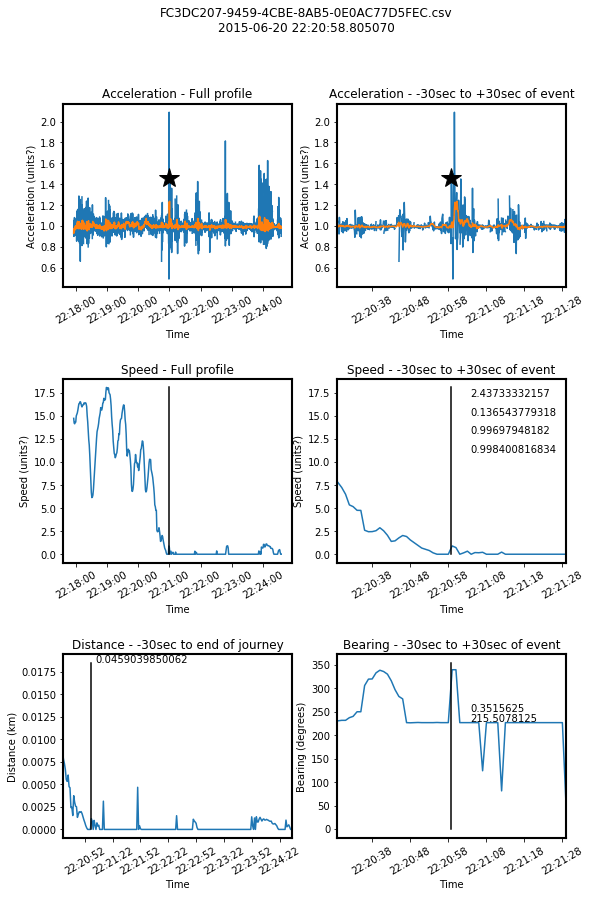

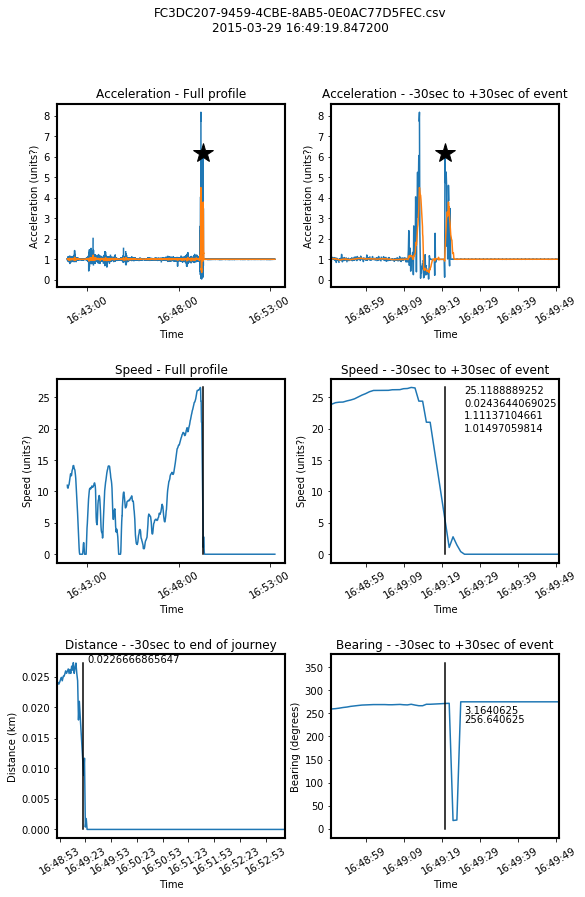

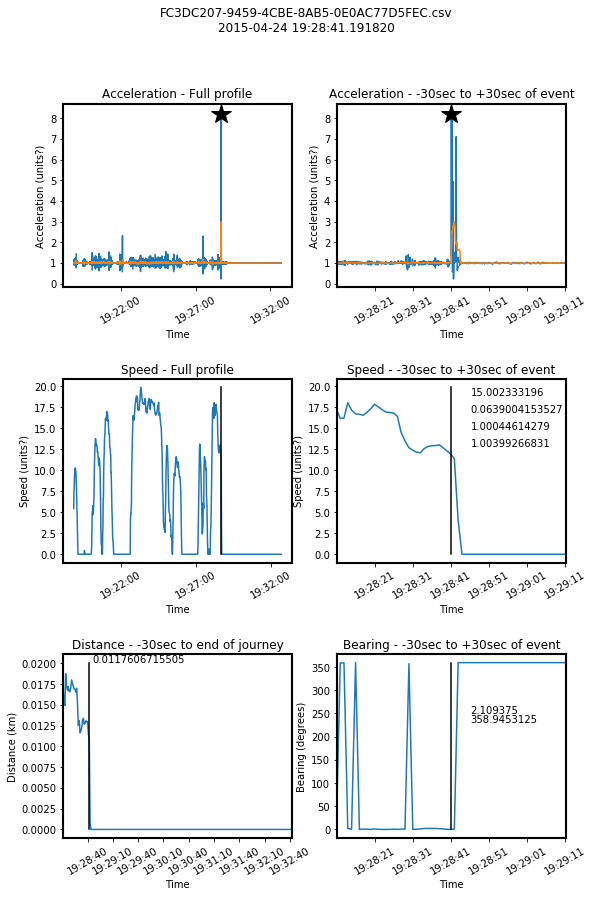

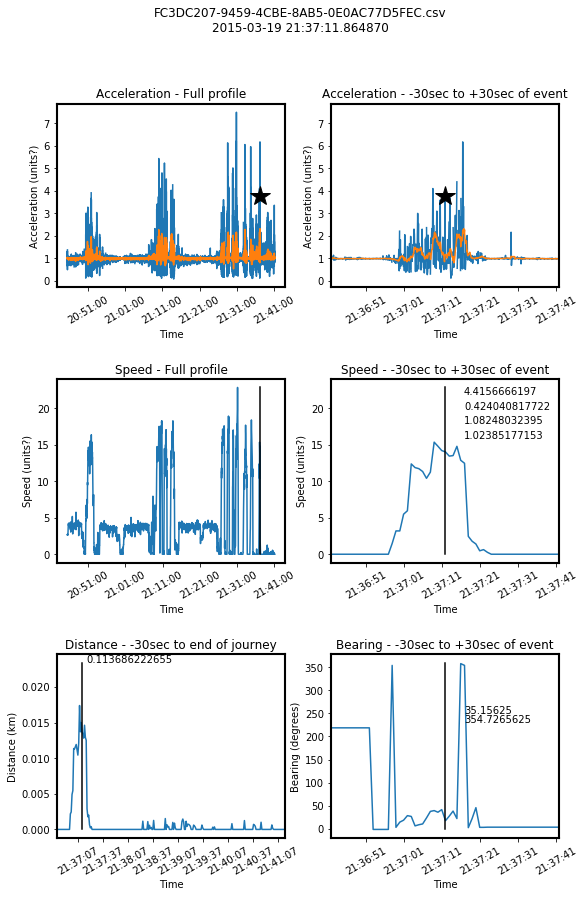

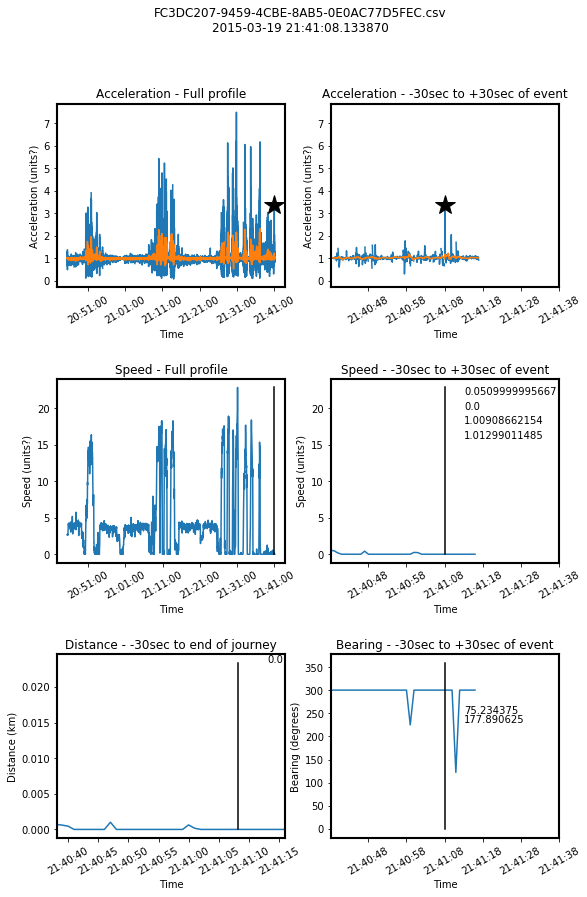

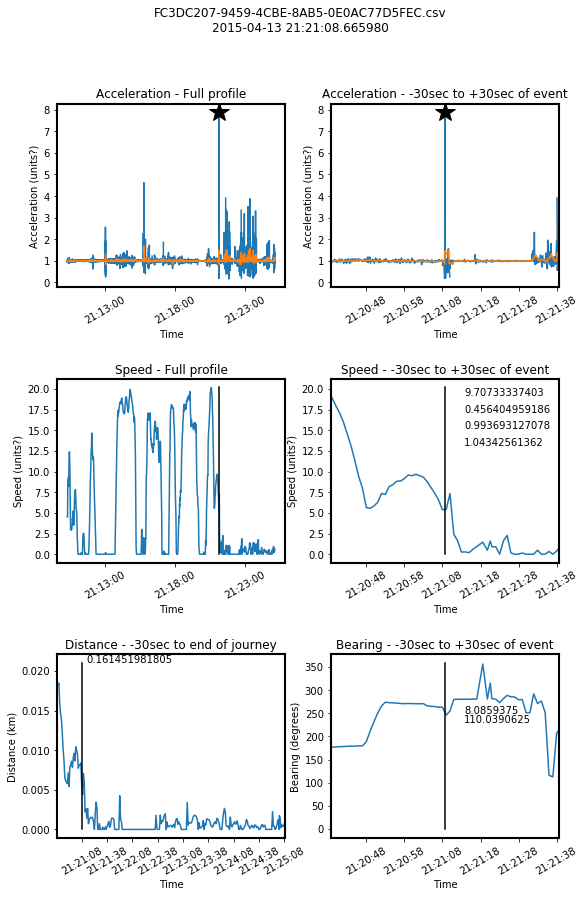

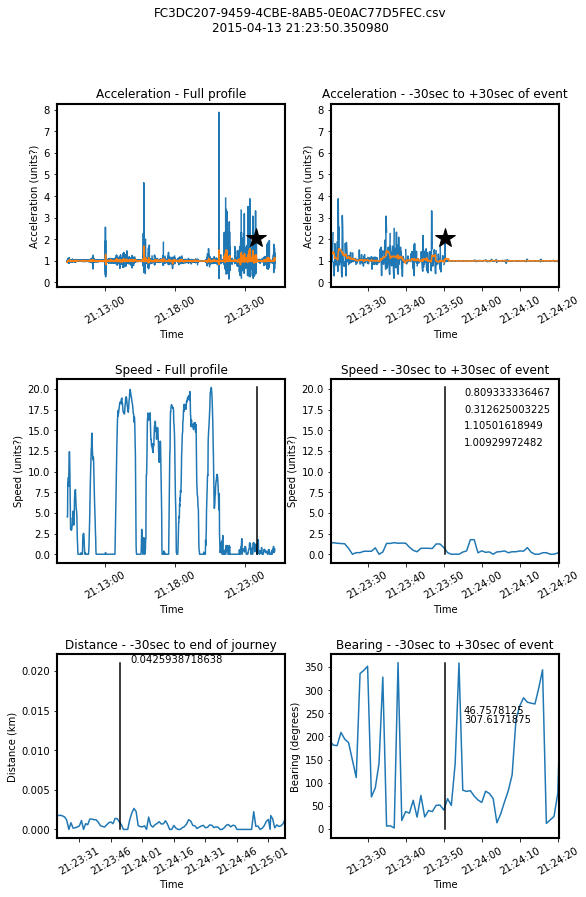

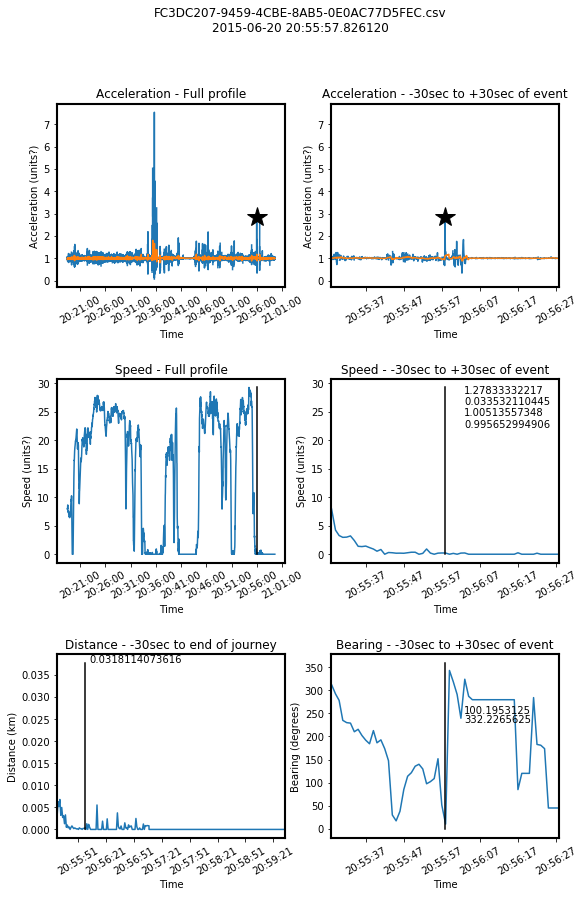

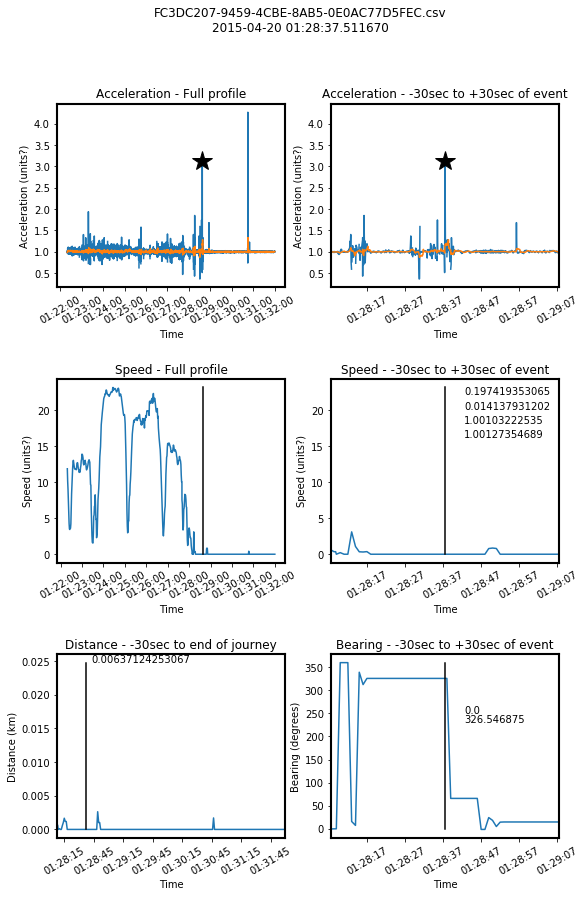

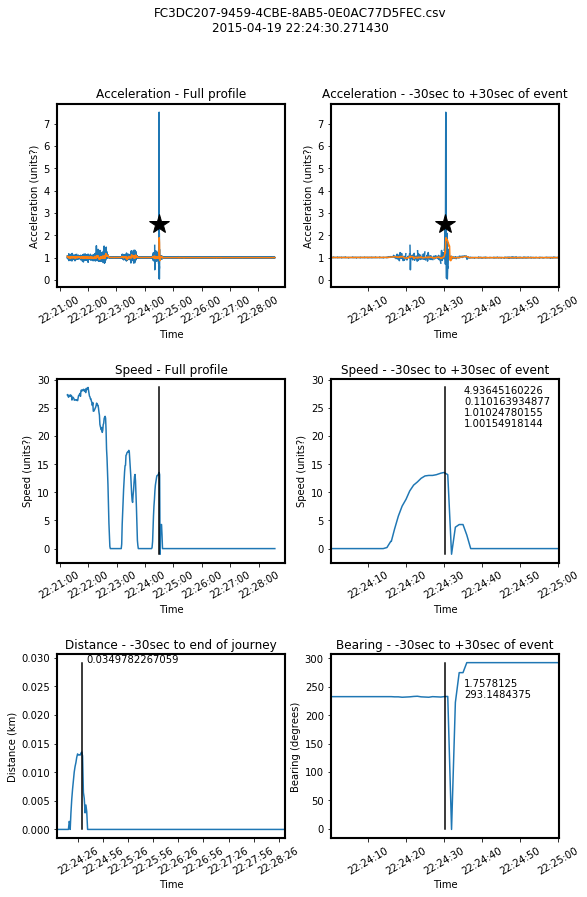

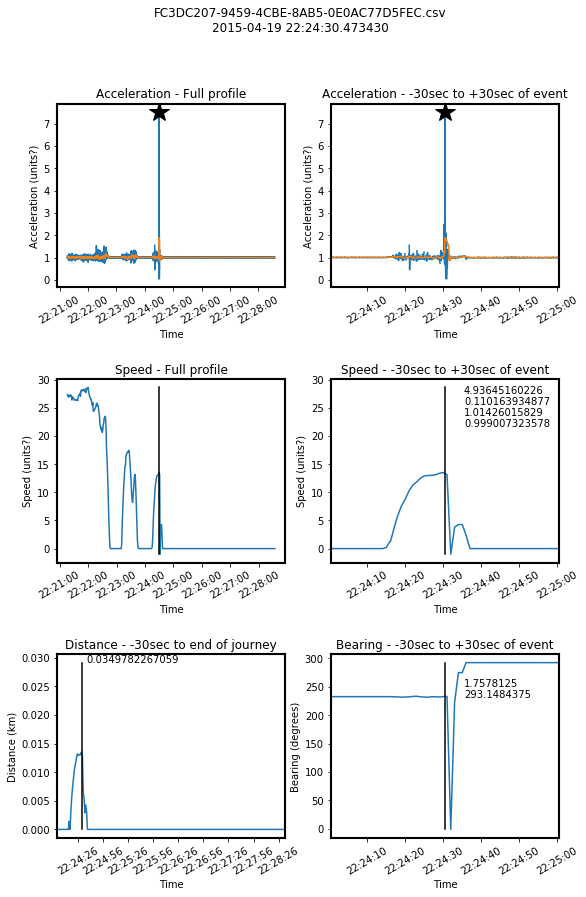

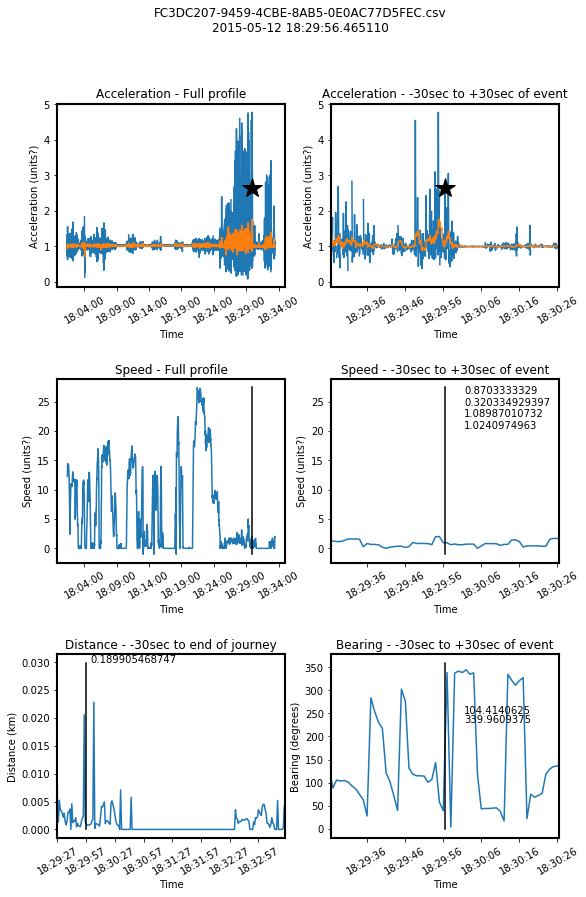

In [46]:
event_cut = event[(event.speed_before>event.speed_after) & (event.distance_after<0.2) & ((event.bearing_after - event.bearing_before)>100)]
for i in range(0,len(event_cut.index)):
    Plot_crash(event_cut.iloc[i:i+1],sorted_dfs[event_cut.driver[i]], rolling_mean[event_cut.driver[i]], gps_dfs[event_cut.driver[i]])





event_cut

In [ ]:
event_cut

In [ ]:
sorted_dfs[0]

In [ ]:
files[0]

In [ ]:
files[0].split('/')[2]

In [ ]:
event_cut['filename'] = files[event_cut.driver.values].split('/')[2]


In [ ]:
event_cut.driver.values

In [ ]:
event_cut

In [ ]:
event_cut = event_cut.drop_duplicates(subset=['driver'],keep='first')

In [ ]:
print(event_cut[['mag','type']])

In [ ]:
event_cut

In [ ]:
def find_events(files, sorted_dfs, rolling_mean, rolling_std, variable, window):
    events_df = pd.DataFrame()
    drivers = []
    filenames = []
    for i in range(0,len(sorted_dfs)):
        for j in range(0,len(sorted_dfs[i].index)):
            if sorted_dfs[i][variable][j] > (rolling_mean[i][variable][j]+(2.75*rolling_std[i][variable][j])):
                if sorted_dfs[i][variable][j] > (sorted_dfs[i][variable].mean()+(5.0*sorted_dfs[i][variable].std())):
                    events_df = events_df.append(sorted_dfs[i].iloc[j])
                    drivers.append(i)
                    filenames.append(files[i].split('/')[2])
    events_df['driver']=drivers
    events_df['filename'] = filenames
    return events_df    


In [ ]:
files[0].split('/')[-1]

In [44]:
test.head()

,accuracy,bearing,height,lat,lon,mag,speed,timestamp,type,x,y,z,driver,speed_before,speed_after,mag_before,mag_after,distance_after,bearing_before,bearing_after
2015-06-20 22:20:58.805070,NaN,NaN,NaN,NaN,NaN,1.458781,NaN,1.434839e+12,accelerometer,-0.722885,-0.070068,-1.265137,1,2.437333,0.136544,0.996979,0.998401,0.045904,0.351562,215.507812
2015-06-22 20:46:44.581220,NaN,NaN,NaN,NaN,NaN,1.467568,NaN,1.435006e+12,accelerometer,-0.094345,1.389175,-0.463730,2,8.150000,0.121068,1.019484,1.006148,0.050356,56.601562,227.460938
2015-03-29 16:49:19.847200,NaN,NaN,NaN,NaN,NaN,6.192798,NaN,1.427648e+12,accelerometer,4.234802,4.147598,-1.792938,3,25.118889,0.024364,1.111371,1.014971,0.022667,3.164062,256.640625
2015-04-24 19:28:41.191820,NaN,NaN,NaN,NaN,NaN,8.199993,NaN,1.429904e+12,accelerometer,0.930817,-1.690674,7.969635,5,15.002333,0.063900,1.000446,1.003993,0.011761,2.109375,358.945312
2015-03-19 21:37:11.864870,NaN,NaN,NaN,NaN,NaN,3.774583,NaN,1.426801e+12,accelerometer,-1.049789,3.541229,0.777893,6,4.415667,0.424041,1.082480,1.023852,0.113686,35.156250,354.726562


In [ ]:
event_cut = event[(event.speed_before>event.speed_after) & (event.distance_after<0.2) & ((event.bearing_after - event.bearing_before)>100)]
for i in range(0,len(event_cut.index)):
    Plot_crash(event_cut.iloc[i:i+1],sorted_dfs[event_cut.driver[i]], rolling_mean[event_cut.driver[i]], gps_dfs[event_cut.driver[i]])

event_cut = event[(event.speed_before>event.speed_after) & (event.distance_after<0.2) & ((event.bearing_after - event.bearing_before)>100)]
for i in range(0,1):
    Plot_crash(event_cut.iloc[i:i+1],sorted_dfs[event_cut.driver[i]], rolling_mean[event_cut.driver[i]], gps_dfs[event_cut.driver[i]])






